## Load PostgreSQL Sample Database

In [1]:
# Create db in postgres

In [2]:
import psycopg2

In [3]:
try: 
    conn = psycopg2.connect("host=127.0.0.1 dbname=postgres user=postgres password=****")
except psycopg2.Error as e: 
    print("Error: Could not make connection to the Postgres database")
    print(e)

In [4]:
try: 
    cur = conn.cursor()
except psycopg2.Error as e: 
    print("Error: Could not get curser to the Database")
    print(e)

In [5]:
conn.set_session(autocommit=True)

In [6]:
try: 
    cur.execute("create database dvdrental")
except psycopg2.Error as e:
    print(e)

In [7]:
cur.close()
conn.close()

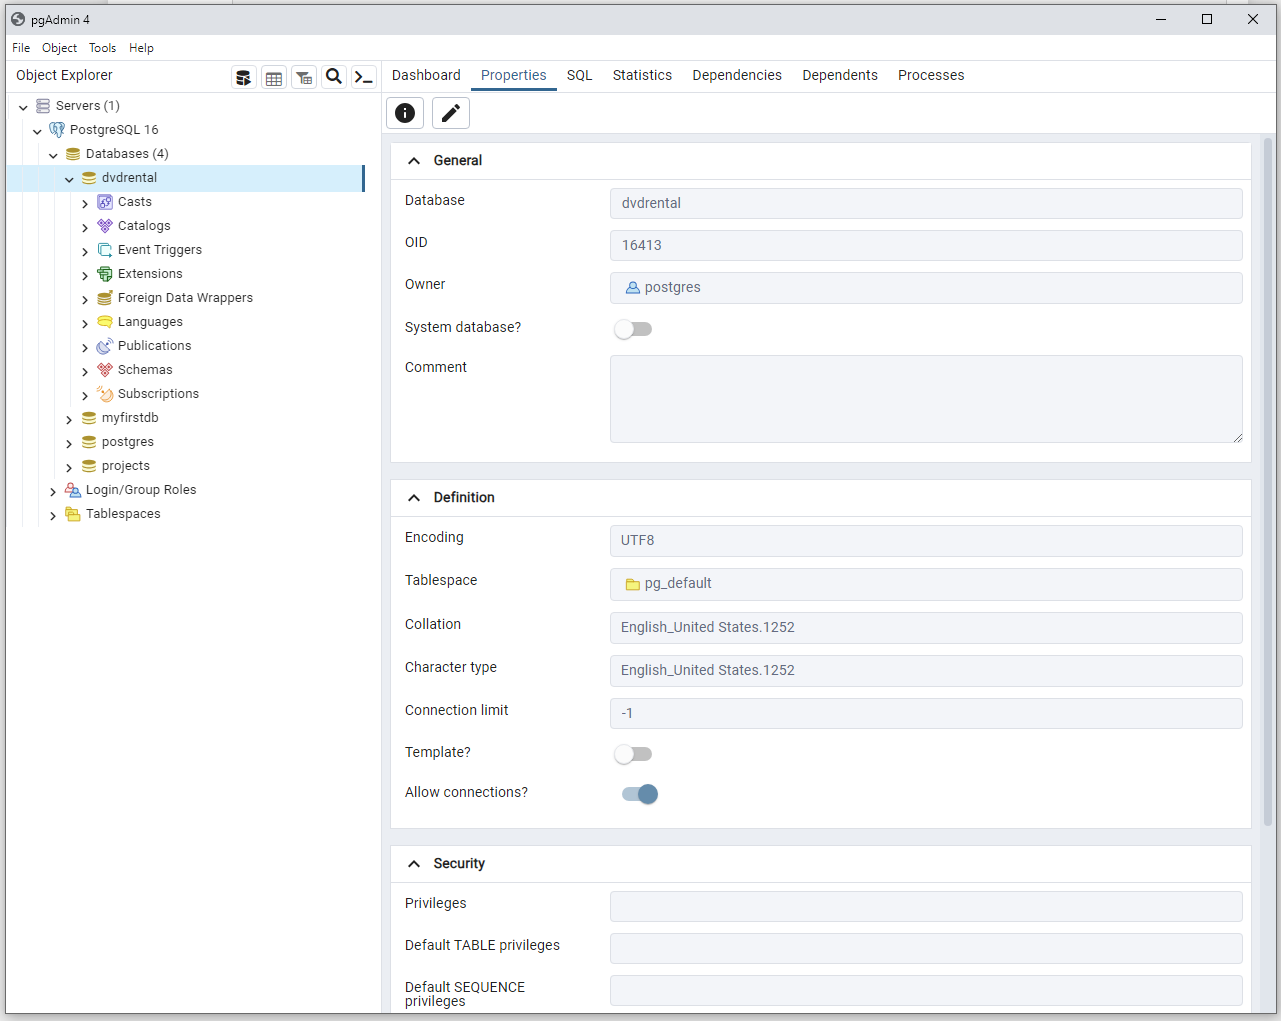

# Restore db using tar file

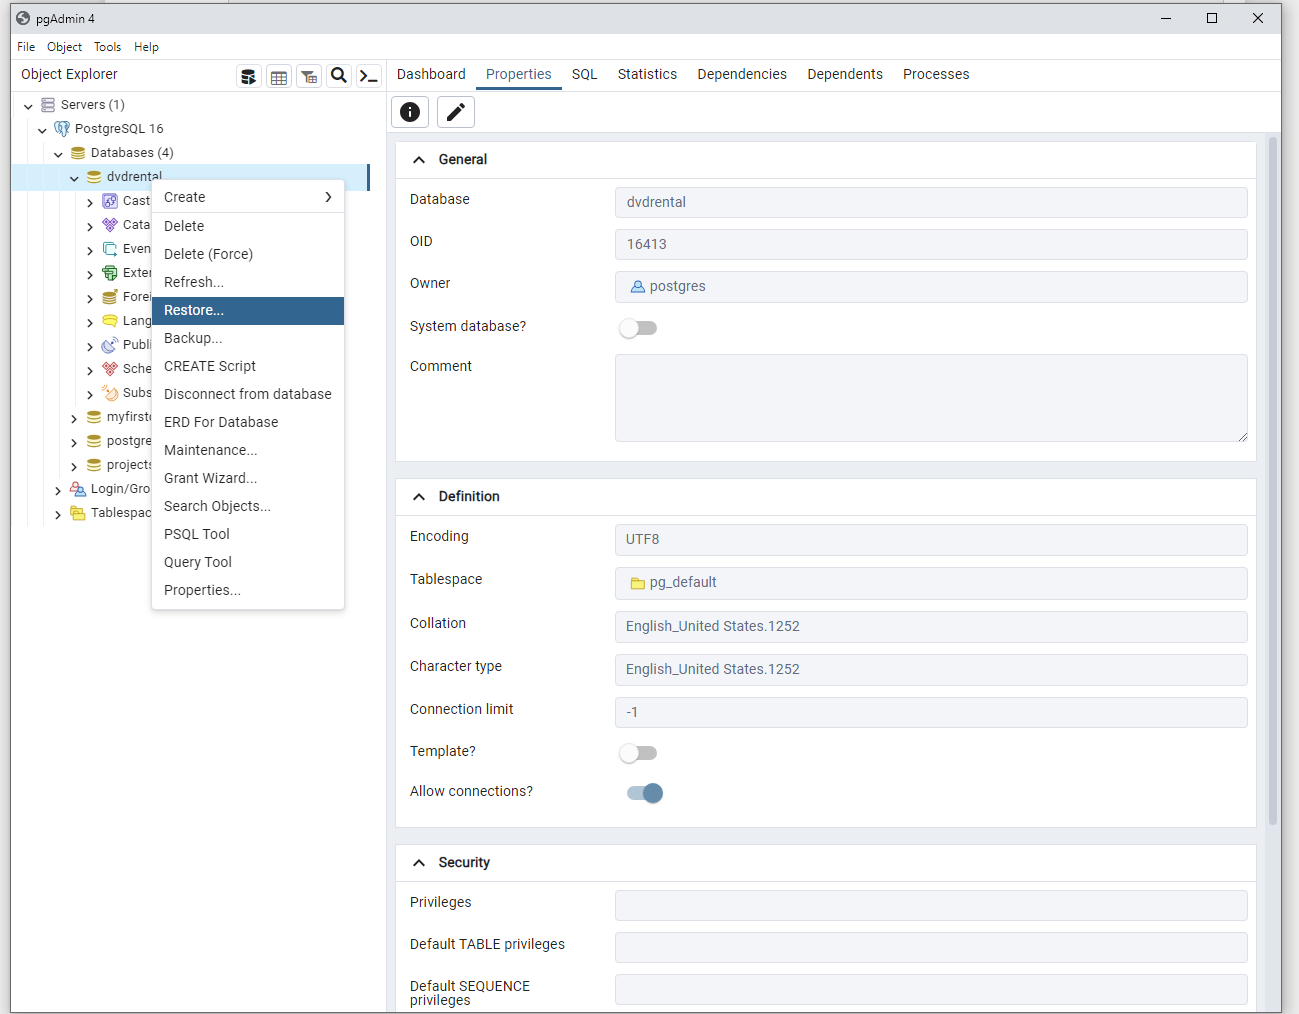
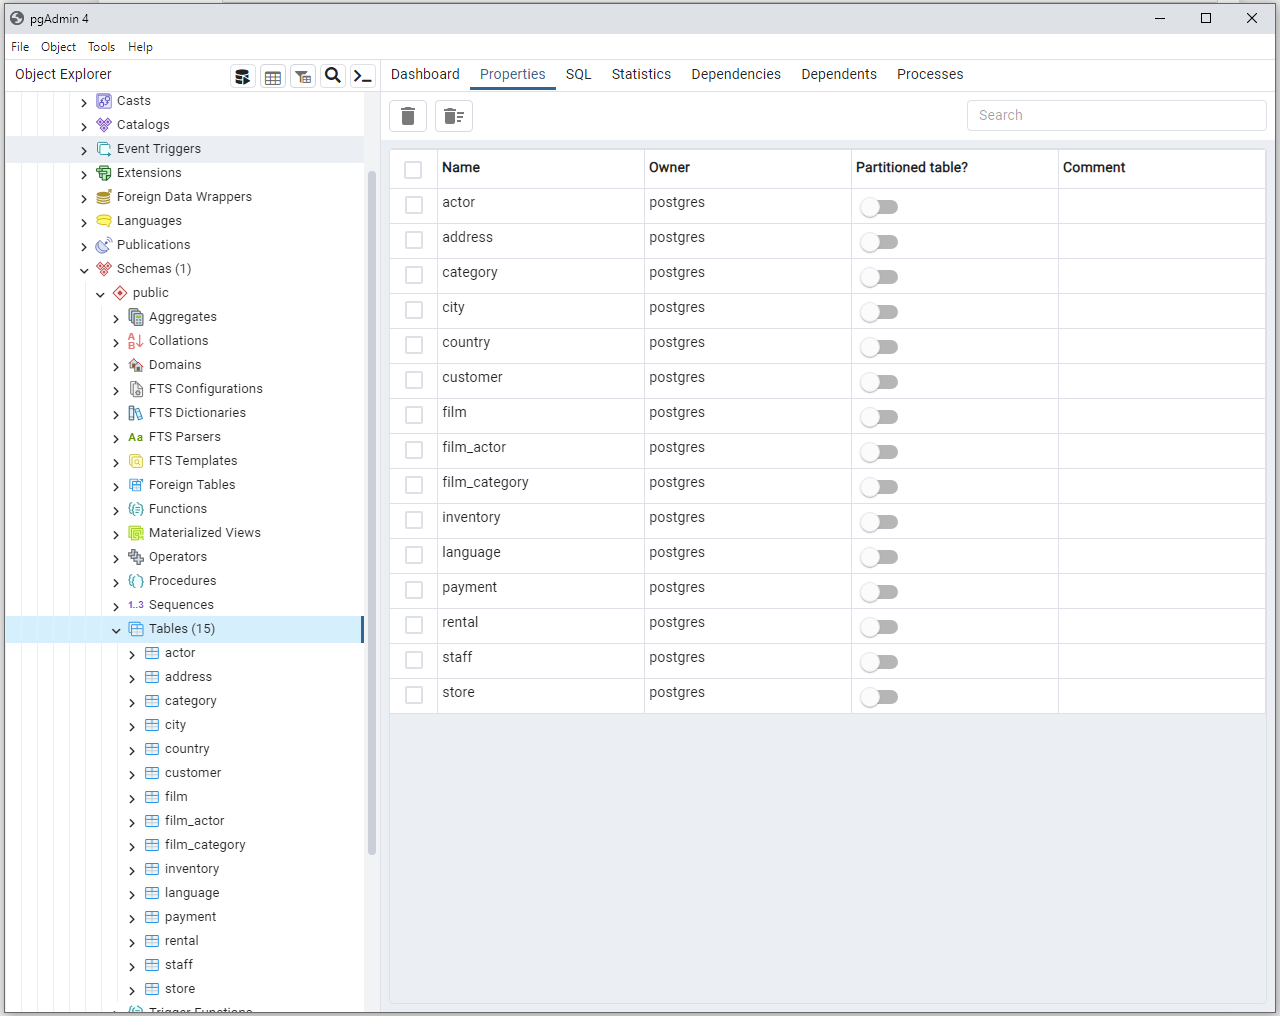

## create dimensional model star schema using ERD 


# erd provided in example
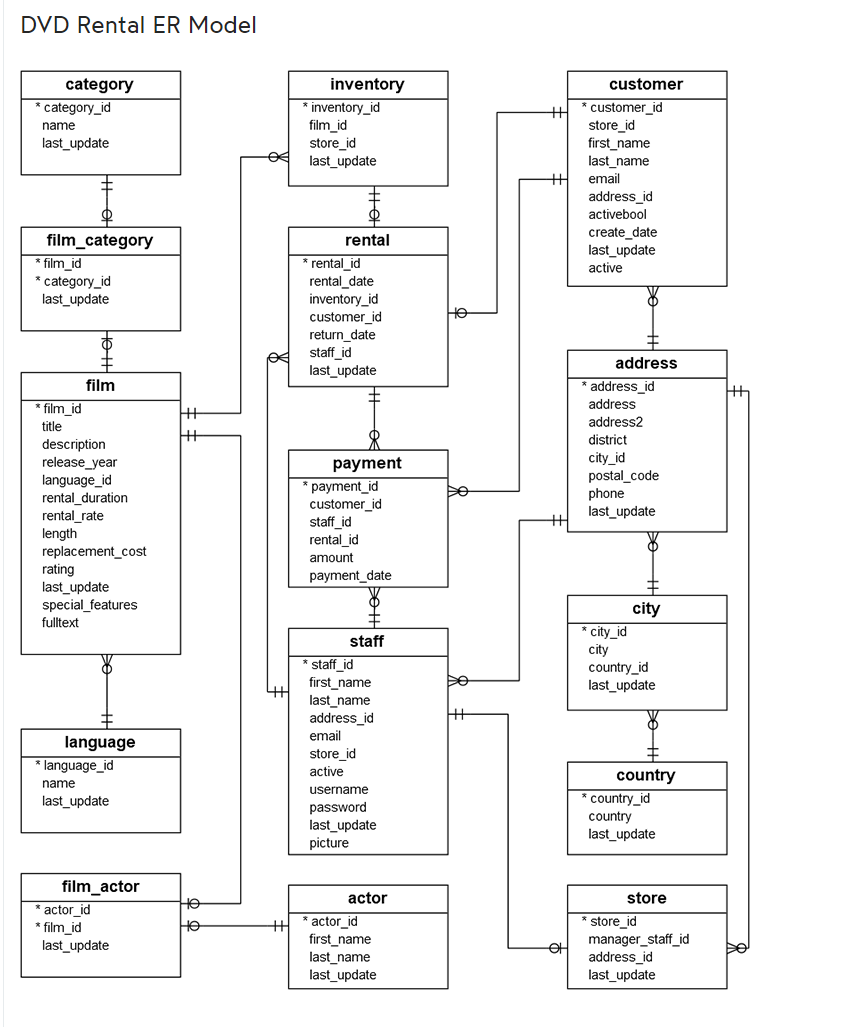

Dimensional Model


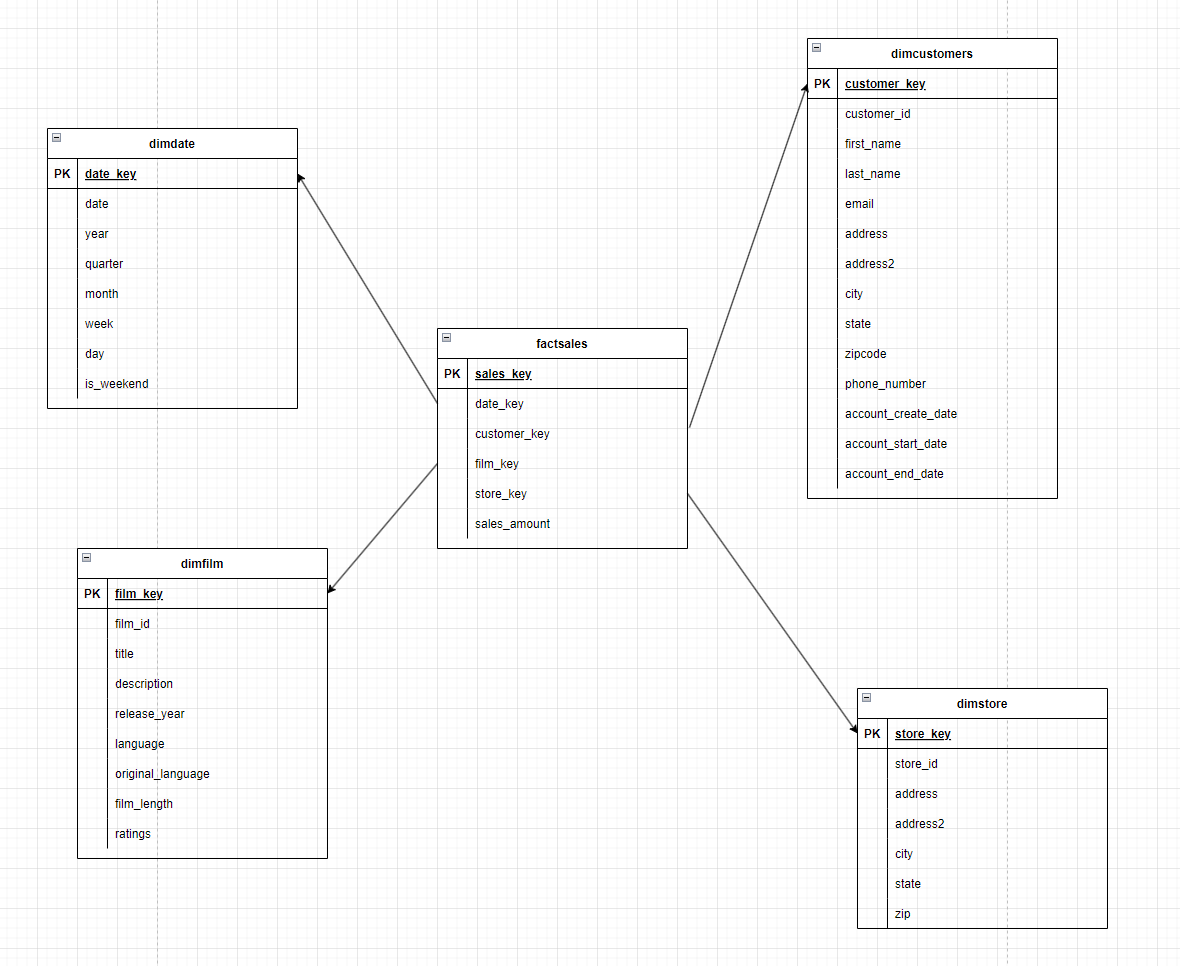

# Create tables in pgAdmin

In [ ]:
DROP TABLE IF EXISTS dimDate;
CREATE TABLE dimDate
    (
      	date_key integer NOT NULL PRIMARY KEY,
        date date NOT NULL,
        year smallint NOT NULL,
        quarter smallint NOT NULL,
        month smallint NOT NULL,
        day smallint NOT NULL,
        week smallint NOT NULL,
        is_weekend boolean
    );
	
	
DROP TABLE IF EXISTS dimCustomer;
CREATE TABLE dimCustomer
    (
     	customer_key	SERIAL PRIMARY KEY,
    	customer_id	smallint NOT NULL,
     	first_name	varchar(45) NOT NULL,
     	last_name	varchar(45) NOT NULL,
     	email	varchar(50),
     	address	varchar(50) NOT NULL,
     	address2	varchar(50),
     	city	varchar(50) NOT NULL,
     	state	varchar(50) NOT NULL,
     	zip_code  varchar(10),
     	phone_number	varchar(20) NOT NULL,
     	account_create_date	timestamp NOT NULL,
     	account_start_date	date NOT NULL,
     	account_end_date	date NOT NULL
    );
	
	
DROP TABLE IF EXISTS dimFilm;
CREATE TABLE dimFilm
	(
		film_key SERIAL PRIMARY KEY,
		film_id	smallint NOT NULL,
		title varchar(255) NOT NULL,
		description text,
		release_year year,
		language varchar(20) NOT NULL,
		film_length smallint NOT NULL,
		ratings varchar(10) NOT NULL
	);
	
	
DROP TABLE IF EXISTS dimStore;
CREATE TABLE dimStore
	(
		store_key SERIAL PRIMARY KEY,
		store_id	smallint NOT NULL,
		address	varchar(50) NOT NULL,
     	address2	varchar(50),
     	city	varchar(50) NOT NULL,
     	state	varchar(50) NOT NULL,
     	zip_code  varchar(10)
	);
    
    
DROP TABLE IF EXISTS factSales;
CREATE TABLE factSales
	(
		sales_key	SERIAL PRIMARY KEY,
		date_key	integer REFERENCES dimDate (date_key),
		customer_key	integer REFERENCES dimCustomer (customer_key),
		film_key	integer REFERENCES dimFilm (film_key),
		store_key	integer REFERENCES dimStore (store_key),
		sales_amount numeric
	);
    


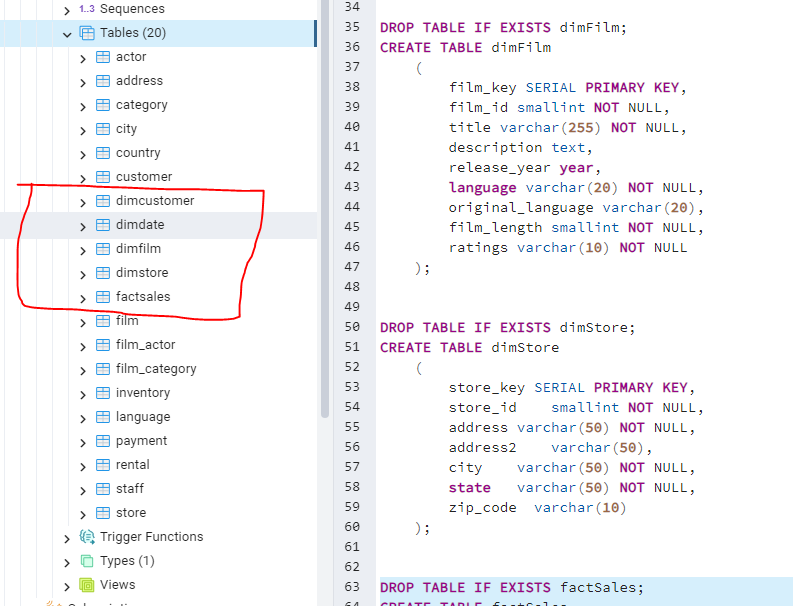

# Populate new tables using data from existing tables

In [ ]:
INSERT INTO dimDate (date_key, date, year, quarter, month, day, week, is_weekend)
SELECT DISTINCT(TO_CHAR(payment_date :: DATE, 'yyyyMMDD')::integer) as date_key,
       date(payment_date)	as date,
       EXTRACT(year FROM payment_date)	as year,
       EXTRACT(quarter FROM payment_date)	as quarter,
       EXTRACT(month FROM payment_date)	as month,
       EXTRACT(day FROM payment_date)	as day,
       EXTRACT(week FROM payment_date)	as week,
       CASE WHEN EXTRACT(ISODOW FROM payment_date) IN (6, 7) THEN true ELSE false END as is_weekend
FROM payment;


INSERT INTO dimCustomer (customer_key, customer_id, first_name, last_name, email, address, 
                         address2, city, state, zip_code, phone_number, 
                         account_create_date, account_start_date, account_end_date)
SELECT  c.customer_id as customer_key,
        c.customer_id,
        c.first_name,
        c.last_name,
        c.email,
        a.address,
        a.address2,
        ci.city,
        a.district as state,
        a.postal_code as zip_code,
        a.phone as phone_number,
        c.create_date as account_create_date,
       now() as account_start_date,
       now() as account_end_date
FROM customer c
JOIN address a  ON (c.address_id = a.address_id)
JOIN city ci    ON (a.city_id = ci.city_id);


INSERT INTO dimFilm (film_key, film_id, title, description, release_year,
					 language, film_length, ratings)
SELECT  f.film_id as film_key,
		f.film_id,
		f.title,
		f.description,
		f.release_year,
		l.name as language,
		f.length as film_length,
		f.rating as ratings
FROM film f
JOIN language l ON (l.language_id = f.language_id);


INSERT INTO dimStore (store_key, store_id, address, address2,
					  city, state, zip_code)
SELECT	s.store_id as store_key,
		s.store_id,
		a.address,
		a.address2,
		c.city,
		a.district as state,
		a.postal_code as zip_code
FROM store s
JOIN address a on (a.address_id = s.address_id)
JOIN city c on (c.city_id = a.city_id);


INSERT INTO factSales (date_key,customer_key, film_key, store_key, sales_amount)
SELECT  DISTINCT(TO_CHAR(p.payment_date :: DATE, 'yyyyMMDD')::integer) as date_key,
		p.customer_id as customer_key,
		i.film_id as film_key,
		i.store_id as store_key,
		p.amount as sales_amount
FROM payment p 
JOIN rental r ON r.rental_id = p.rental_id
JOIN inventory i ON i.inventory_id = r.inventory_id;